In [1]:
# Exercise_3:
# Time Series Prediction using LSTM
# TODO start**
# Names: 
# Date: 
# TODO end**

In [24]:
#%% import modules
import torch
import torch.nn as nn

# seaborn is a libraray which works on top of matplotlib and offers more visualitation tools
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for noramlization
from sklearn.preprocessing import MinMaxScaler

# module for interoperable file-operations
import os
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
print(f'Path of this exercise: {path}')

def plot_xy(datenreihen, name=["Messwerte"], x="X", y="Y", title=None, diagram="show", size={'x_min': 0, 'x_max': 0, 'y_min': 0, 'y_max': 0}, fixed_size=False):
    """
    Diese Funktion nimmt je zwei Datenreihen und plottet diese in Abhängigkeit
    zueinander in ein Diagramm.
    """
    plt.clf()
    for datenreihe in datenreihen:
        plt.plot(datenreihe[0], datenreihe[1])
    plt.legend(name)
    plt.grid()
    plt.xlabel(x)
    plt.ylabel(y)
    if(fixed_size):
        plt.xlim(size['x_min'], size['x_max'])
        plt.ylim(size['y_min'], size['y_max'])
    if(title != None):
        plt.title(title)
    else:
        plt.title(name[0])
    if(diagram == "show"):
        plt.show()
    elif(diagram == "save"):
        plt.savefig(os.path.join("plots", title + ".png"))

Path of this exercise: /hdd/repository/hcu-ma-gmt-big-data-analysis/data/ex3


In [25]:
# %% CUDA for PyTorch
# Right at the beginning: check if a cuda compatible GPU is available in your computer. 
# If so, set device = cuda:0 which means that later all calculations will be performed on the graphics card. 
# If no GPU is available, the calculations will run on the CPU, which is also absolutely sufficient for the examples in these exercises.
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#cudnn.benchmark = True
# device ='cuda:0'

if device.type == 'cpu':
    device_num = 0
    print('No GPU available.')
else:
    device_num = torch.cuda.device_count()
    print('Device:', device, '-- Number of devices:', device_num)

Device: cuda:0 -- Number of devices: 1


In [26]:
# Mounting Google Drive locally 
# from google.colab import drive
#drive.mount("/content/drive", force_remount=True)
# drive.mount('/content/drive')
# you can also choose one of the other options to load data
# therefore see https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA

[[1999   11    1    0    2  457]
 [1999   11    1    0    3  456]
 [1999   11    1    0    4  456]
 ...
 [2001   10   29    4    8  434]
 [2001   10   29    4    9  433]
 [2001   10   29    4   10  432]]


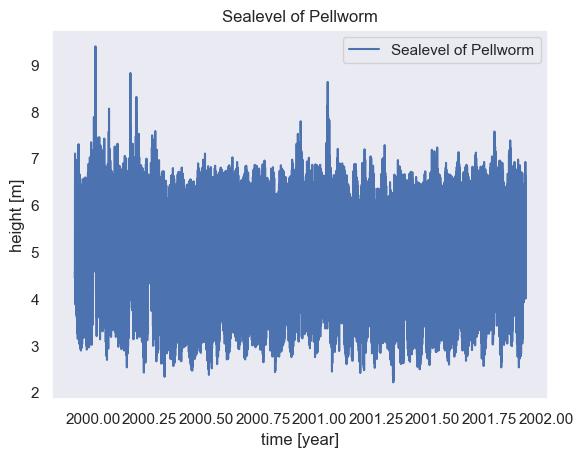

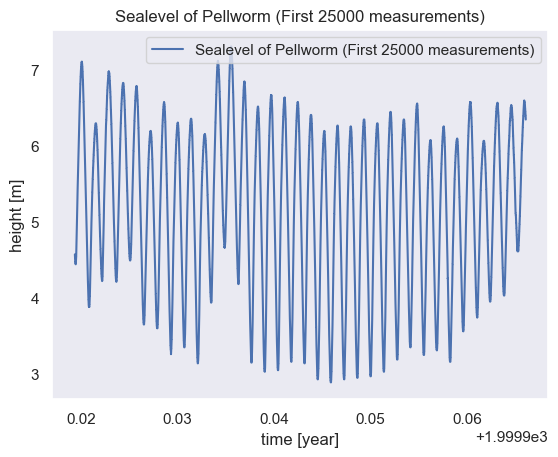

In [66]:
# %% read pellworm data
# TODO start**    
data_path = os.path.join(path, "data/sea_level_dataset/pellworm_data.csv")
with open(data_path, "r") as f:
    data = f.readlines()
for i, e in enumerate(data):
    e = e.strip().split(",")
    for j, x in enumerate(e):
        e[j] = int(x)
    data[i] = e
data = np.array(data)
data_time = []
data_sealevel = []
# print(data)

# Convert year, month, day, hour, minute -> float of year
for i in data:
    data_time.append(i[0]+(i[1]/12)+(i[2]/(12*31))+(i[3]/(12*31*24))+(i[4]/(12*31*24*60)))
    data_sealevel.append(i[5]/100)
plot_xy([[data_time, data_sealevel]],
        name=["Sealevel of Pellworm"],
        x="time [year]", y="height [m]")
head_num = 25000
plot_xy([[data_time[:head_num], data_sealevel[:head_num]]],
        name=[f"Sealevel of Pellworm (First {head_num} measurements)"],
        x="time [year]", y="height [m]")

['anagrams', 'anscombe', 'attention', 'brain_networks', 'car_crashes', 'diamonds', 'dots', 'dowjones', 'exercise', 'flights', 'fmri', 'geyser', 'glue', 'healthexp', 'iris', 'mpg', 'penguins', 'planets', 'seaice', 'taxis', 'tips', 'titanic']


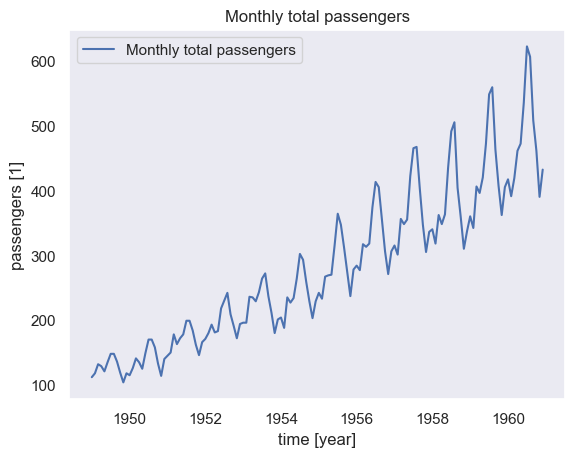

In [46]:
#%% load flight passenger data from seaborn library
# there are some datasets in the seaborn library included
print(sns.get_dataset_names())
# TODO start**
# we can use e.g. the flight dataset
flight_data = sns.load_dataset("flights")
flight_data_time = []
flight_data_passengers = []
for i in np.array(flight_data):
    time = int(i[0])
    match str(i[1]):
        case "Jan":
            time += 0/12
        case "Feb":
            time += 1/12
        case "Mar":
            time += 2/12
        case "Apr":
            time += 3/12
        case "May":
            time += 4/12
        case "Jun":
            time += 5/12
        case "Jul":
            time += 6/12
        case "Aug":
            time += 7/12
        case "Sep":
            time += 8/12
        case "Oct":
            time += 9/12
        case "Nov":
            time += 10/12
        case "Dec":
            time += 11/12
    flight_data_time.append(time)
    flight_data_passengers.append(int(i[2]))
    
#...
# data = ???
# TODO end**    
plot_xy([[flight_data_time, flight_data_passengers]],
        name=["Monthly total passengers"],
        x="time [year]", y="passengers [1]")
# TODO start**
# Explain differences
# TODO end**

In [ ]:
#%% cut the end of the time series as test data
# TODO start** 
test_data_size =
# TODO end** 
# trva = train and val
trva_data = data[:-test_data_size]
test_data = data[-test_data_size:] 
print('Length of train data:', len(trva_data))
print('Length of test data:', len(test_data))

In [ ]:
#%% normalize data with MinMax Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
trva_data_normalized = scaler.fit_transform(trva_data.reshape(-1, 1))
print(trva_data_normalized[:5])
print(trva_data_normalized[-5:])


In [ ]:
#%% convert to Torch Tensor
# view(-1) is similar to reshape for tensor and the array size is inferred for the -1 dimension
trva_data_normalized = torch.FloatTensor(trva_data_normalized).view(-1)

In [ ]:
#%% create sequences
# function to create sequences of input (passenger of train_window months) and ...
# ... output passenger of train_window+1 month
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

# Set an appropiate Train window
# TODO start**
train_window =
# TODO end**

# create sequences 
trva_inout_seq = create_inout_sequences(trva_data_normalized, train_window)

# print the first 3 sequences
print(trva_inout_seq[:3])

In [ ]:
#%% Split train sequences in train and val sequences
# remember: we ahve already taken test data -> end of time series
sample_num = {'all': len(trva_inout_seq), 
              'train': int(0.8*len(trva_inout_seq)),
              'val': int(0.2*len(trva_inout_seq))}

# idx shuffle
idx = list(range(sample_num['all']))
np.random.shuffle(idx)
# assign idx to each sample
sample_idx = {'all': idx[:], 
              'train': idx[0:sample_num['train']],
              'val': idx[sample_num['train']:]}

train_inout_seq = [ trva_inout_seq[i] for i in sample_idx['train']]
val_inout_seq = [ trva_inout_seq[i] for i in sample_idx['val']]

In [ ]:
#%% LSTM architecture
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim,
                    num_layers):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
        # Only take the output from the final timestep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred.view(-1)

In [ ]:
#%% create an instance of class LSTM
# Set an appropiate Train window
# TODO start**
input_dim =  #feature dimension of input
hidden_dim =  # number of hidden neurons in LSTM
batch_size = 1 #we do not merge the sequences into batches. Therefore the batch_size is 1.
output_dim =  # feature dimension of output
num_lstm_layers =         
net = LSTM()
# TODO end**

In [ ]:
#%% Send networks to GPU (if you have one which supports cuda) for faster computations
# The network itself must also be sent to the GPU. Either you write net = RegressNet() and then later net.to(device) or directly net = RegressNet().to(device)
# The latter option may have the advantage that the instance net is created directly on the GPU, whereas in variant 1 it must first be sent to the GPU.
if device_num>1:
    print("Let's use", device_num, "GPU's")
    net = nn.DataParallel(net)
net.to(device) 
print(net)

In [ ]:
#%% specify hyperparameter loss function and optimizer
# TODO start**
num_epochs = 
num_learning_rate = 
loss_function = 
optimizer = 
#print(net)
# TODO end**

In [ ]:
#%% Train the Model

# TODO start**
loss_epoch_train = []
loss_epoch_val = []
for epoch in range(num_epochs):
    loss_seq_train = []
    loss_seq_val = []
    
    for seq, labels in train_inout_seq:
        seq, labels = seq.to(device), labels.to(device)
        net.hidden = net.init_hidden()
        optimizer.zero_grad()
        y_pred_train = net(seq)
        
        seq_loss = loss_function(y_pred_train, labels)
        loss_seq_train.append(seq_loss.data.cpu().numpy())
        seq_loss.backward()
        optimizer.step()
        
       
    for seq, labels in val_inout_seq:
        seq, labels = seq.to(device), labels.to(device)
        y_pred_val = net(seq)
        
        seq_loss = loss_function(y_pred_val, labels)
        loss_seq_val.append(seq_loss.data.cpu().numpy())
        
    loss_epoch_train.append(np.mean(loss_seq_train))
    loss_epoch_val.append(np.mean(loss_seq_val))
    print('Epoch '+str(epoch)+'/'+str(num_epochs)+': Train-Loss: '+str(np.round(loss_epoch_train[-1],4))+'; Val-Loss: '+str(np.round(loss_epoch_val[-1],4)))        
# TODO end**
    
plt.figure()
plt.plot(range(num_epochs), loss_epoch_train, color='r', marker='.', label = 'train-loss')
plt.plot(range(num_epochs), loss_epoch_val, color='b', marker='.', label = 'val-loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.savefig('/content/drive/My Drive/bda_lab/ex3/results/lstm_loss.png')
plt.show()

In [ ]:
#%% Make predictions
# TODO start**
fut_pred = 
# TODO end**
# the last train_window trva data are the first input for the prediction...
test_inputs = trva_data_normalized[-train_window:].tolist()
print(test_inputs)


# ...and each new prediction is append to the input
net.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    seq = seq.to(device)
    with torch.no_grad():
        net.hidden = net.init_hidden()
        test_inputs.append(net(seq).item())

#print only the predictions (the last fut_pred elements in the list)
print(test_inputs[-fut_pred:])


# since we normalized the dataset for training the predicted values are also normalized
# undo with inverse normalization
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

In [ ]:
#%% plot for whole time window
plt.title('Passenger Prediction 12 Months')
plt.xlabel('Month')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
# matplotlib default colors
# print(plt.rcParams['axes.prop_cycle'].by_key()['color'])
plt.plot(trva_data, color='#1f77b4', label='train+val reference')
x_ref = np.arange(trva_data.shape[0], trva_data.shape[0]+test_data.shape[0], 1)
x_pred = np.arange(trva_data.shape[0], trva_data.shape[0]+fut_pred, 1)
plt.plot(x_ref,test_data, color='#ff7f0e', label='test reference')
plt.plot(x_pred,actual_predictions, color='#2ca02c', label='test prediction')
plt.savefig('/content/drive/My Drive/bda_lab/ex3/results/lstm_forecast.png')
plt.legend()
plt.show()

In [ ]:
#%% zoom plot for test area
plt.title('Zoom: Test Prediction')
plt.xlabel('Month')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(x_ref,test_data, color='#ff7f0e', label='test reference')
plt.plot(x_pred,actual_predictions, color='#2ca02c', label='test prediction')
plt.savefig('/content/drive/My Drive/bda_lab/ex3/results/lstm_test_zoom.png')
plt.legend()
plt.show()